# Introduction to fitting and optimization

In this tutorial, two libraries and several optimization routines will be used to fit a single crystal peak.
- `scipy.optimize.curve_fit`
- `scipy.optimize.least_squares`
- `lmfit`

The overview is as follows:
1. Loading and plotting data
2. Definining and fitting a model
3. Inspecting and interpreting output

### First begin by loading the required libaries.

In [11]:
# --- import libaries --

import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize
import lmfit
import h5py

### Loading data with `h5py`

Load the mantid workspace with histogramed counts vs. $d$-spacing bin edges. The `values` contain the counts and `errors` contain the uncertanties.

In [12]:
# --- load data ---

f = h5py.File('../data/elastic.nxs', mode='r')

ws = f['mantid_workspace_1/workspace/']
d_spacing_bin_edges = ws['axis1'][()]

counts  = ws['values'][()].flatten()
errors  = ws['errors'][()].flatten()

f.close()

### Plotting the data with `matplotlib`

It is necessary to calculate the $d$-spacing bin centers from the bin edges. The number of histogram bins is one less than the number of edges.
$$d(\mathrm{center})=\frac{d(\mathrm{left})+d(\mathrm{right})}{2}$$

Matplotib can appropriately plot errorbars.


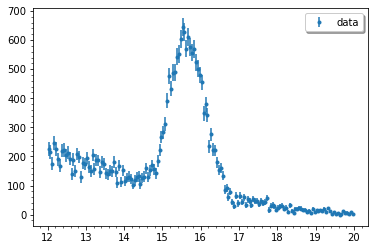

In [13]:
# --- plot data ---

d_spacing = 0.5*(d_spacing_bin_edges[1:]+d_spacing_bin_edges[:-1])

fig, ax = plt.subplots(1,1)
ax.errorbar(d_spacing, counts, yerr=errors, fmt='.', label='data')
ax.legend(shadow=True)
ax.minorticks_on()

### Defining a model as a function and guessing initial parameters

The peak could be modeled as a Gaussian peak with a linear sloping background.

$$y=Ae^{-\frac{(d-\mu)^2}{2\sigma^2}}+B+cd$$

Guassian peak
1. $A=\mathrm{amplutude}$
2. $\mu=\mathrm{mean}$
3. $\sigma=\mathrm{standard\;deviation}$

Sloping background
1. $B=\mathrm{intercept}$
2. $c=\mathrm{slope}$

It is illustrative to guess the initial parameters. This is often a helpful staring point for fitting a model. This initial guess is labeled as `p0`.

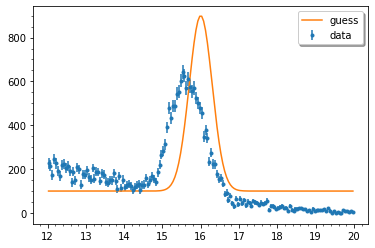

In [14]:
# --- define model ---

def model(d, A, mu, sigma, B, c):

    return A*np.exp(-0.5*(d-mu)**2/sigma**2)+B+c*d

A, mu, sigma, B, c = 800, 16, 0.3, 100, 0

p0 = (A, mu, sigma, B, c)

ax.plot(d_spacing, model(d_spacing, *p0), label='guess')
ax.legend(shadow=True)
fig

### Fitting the model using `scipy.optimize.curve_fit`

Since the model can be expressed as a $y=f(d,\mathrm{parameters})$, `curve_fit` is a good candidate. Providing the model function, initial guess, independent and dependent variables, it gives optimized parameters `popt` and the covariance matrix of the parameters `pcov`.

Since the experimental uncertainties are available and correctly scaled, they can be incorporated into the fit. Here, Levenberg-Marquardt method is used.

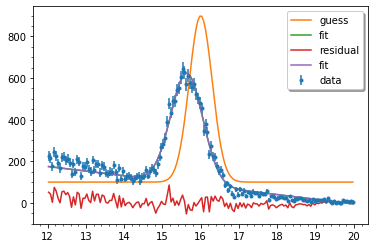

In [21]:
# --- fit model ---

popt, pcov = scipy.optimize.curve_fit(model, d_spacing, counts, p0=p0,
                                      sigma=errors, absolute_sigma=True,
                                      method='lm')

ax.plot(d_spacing, model(d_spacing, *popt), label='fit')
ax.legend(shadow=True)
fig

### Plotting the residuals

It is good practice to plot the residuals of the final fit to ensure the fit is of good quality. This is indicated by absence of systematic trends whic suggest the model is not correct. If the model describes the data well, then the residuals should be fluctiations about zero corresponding to experimental uncertainty.

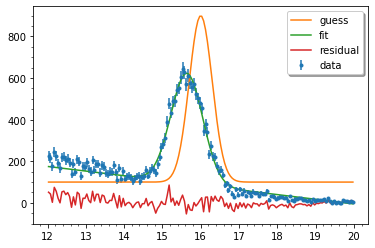

In [16]:
# --- plot residuals ---

def residual(d, counts, A, mu, sigma, B, c):
    
    return counts-model(d, A, mu, sigma, B, c)

ax.plot(d_spacing, residual(d_spacing, counts, *popt), label='residual')
ax.legend(shadow=True)
fig

### Calculating errors on fitted paramters

The covariance matrix provides the correlation between fitted parameters. 

$$c_{ij}=\begin{pmatrix} 
c_{AA} & c_{A\mu} & c_{A\sigma} & c_{AB} & c_{Ac}  \\ 
c_{\mu A} & c_{\mu\mu} & c_{\mu\sigma} & c_{\mu B} & c_{\mu c}  \\ 
c_{\sigma A} & c_{\sigma\mu} & c_{\sigma\sigma} & c_{\sigma B} & c_{\sigma c}  \\ 
c_{BA} & c_{B\mu} & c_{B\sigma} & c_{BB} & c_{Bc}  \\ 
c_{cA} & c_{c\mu} & c_{c\sigma} & c_{cB} & c_{cc}  \\ 
\end{pmatrix}$$

The diagonal of the matrix corresponds to the variance of the individual parameters. Simply taking the square root gives the errors (standard deviation).

In [17]:
# --- calculate errors ---

perr = np.sqrt(np.diag(pcov))

print('Fitted uncertanties as 1-std using curve_fit')
print('A     = {:8.3f} ± {:5.3f}'.format(popt[0],perr[0]))
print('mu    = {:8.3f} ± {:5.3f}'.format(popt[1],perr[1]))
print('sigma = {:8.3f} ± {:5.3f}'.format(popt[2],perr[2]))
print('B     = {:8.3f} ± {:5.3f}'.format(popt[3],perr[3]))
print('c     = {:8.3f} ± {:5.3f}'.format(popt[4],perr[4]))

Fitted uncertanties as 1-std using curve_fit
A     =  529.852 ± 9.095
mu    =   15.638 ± 0.007
sigma =    0.419 ± 0.007
B     =  445.679 ± 8.216
c     =  -22.544 ± 0.434


### Fitting the model using `scipy.optimize.least_squares`

It is also possible to define the least squares problem equivalently to the curve fitting probem. The objective function to optimize is the $\chi^2$ parameter which accounts for the residuals weighted by the experimental uncertainties. That is,

$$\chi^2=\sum_i\frac{[y_i-f(d,\mathrm{parameters}]^2}{\sigma_i^2}$$

which is the sum of weighted deviations $[y_i-f(d,\mathrm{parameters})]/\sigma_i$. Levenberg-Marquardt can be used again and a solution os returned that contains the fitted parameters `sol.x` and weighted Jacobian `sol.jac`. The covariance matrix is constructed from the Jacobian according to 

$$\boldsymbol{C}=\boldsymbol{J}_w^\intercal\boldsymbol{J}_w$$

that contains the weight matrix $\boldsymbol{W}$.

In [23]:
# --- define weighted least squares problem ---

def weighted_deviations(x, d, counts, errors):

    A, mu, sigma, B, c = x

    return residual(d, counts, A, mu, sigma, B, c)/errors

sol = scipy.optimize.least_squares(weighted_deviations, x0=p0,
                                   args=(d_spacing, counts, errors),
                                   method='lm')

vals = sol.x

J = sol.jac
cov = np.linalg.inv(J.T.dot(J))

err = np.sqrt(np.diag(cov))

print('Fitted uncertanties as 1-std using least_squares')
print('A     = {:8.3f} ± {:5.3f}'.format(vals[0],err[0]))
print('mu    = {:8.3f} ± {:5.3f}'.format(vals[1],err[1]))
print('sigma = {:8.3f} ± {:5.3f}'.format(vals[2],err[2]))
print('B     = {:8.3f} ± {:5.3f}'.format(vals[3],err[3]))
print('c     = {:8.3f} ± {:5.3f}'.format(vals[4],err[4]))

Fitted uncertanties as 1-std using least_squares
A     =  529.852 ± 9.095
mu    =   15.638 ± 0.007
sigma =    0.419 ± 0.007
B     =  445.679 ± 8.216
c     =  -22.544 ± 0.434


In [19]:
chi2dof = np.sum(sol.fun**2)/(sol.fun.size-sol.x.size)
cov *= chi2dof

stderr = np.sqrt(np.diag(cov))

print('Fitted uncertanties as 1-stderr using least_squares')
print('A     = {:8.3f} ± {:5.3f}'.format(vals[0],stderr[0]))
print('mu    = {:8.3f} ± {:5.3f}'.format(vals[1],stderr[1]))
print('sigma = {:8.3f} ± {:5.3f}'.format(vals[2],stderr[2]))
print('B     = {:8.3f} ± {:5.3f}'.format(vals[3],stderr[3]))
print('c     = {:8.3f} ± {:5.3f}'.format(vals[4],stderr[4]))

Fitted uncertanties as 1-stderr using least_squares
A     =  529.852 ± 13.914
mu    =   15.638 ± 0.011
sigma =    0.419 ± 0.010
B     =  445.679 ± 12.569
c     =  -22.544 ± 0.664


In [20]:
# --- use constrained optimization ---

def weighted_residual(params, d, counts, errors):

    A = params['A']
    mu = params['mu']
    sigma = params['sigma']
    B = params['B']
    c = params['c']

    return residual(d, counts, A, mu, sigma, B, c)/errors

params = lmfit.Parameters()
params.add('A', value=A, min=0, max=np.inf)
params.add('mu', value=mu, min=-np.inf, max=np.inf)
params.add('sigma', value=sigma, min=0, max=np.inf)
params.add('B', value=B, min=0, max=np.inf)
params.add('c', value=c, min=-np.inf, max=np.inf)

result = lmfit.minimize(weighted_residual, params,
                        args=(d_spacing, counts, errors))

print('Fitted uncertanties as 1-stderr using lmfit')
for key in params.keys():
    value, stderr = result.params[key].value, result.params[key].stderr
    print('{:7} = {:8.3f} ± {:5.3f}'.format(key,value,stderr))

Fitted uncertanties as 1-stderr using lmfit
A       =  529.853 ± 13.914
mu      =   15.638 ± 0.011
sigma   =    0.419 ± 0.010
B       =  445.679 ± 12.569
c       =  -22.544 ± 0.664
